In [1]:
import pandas as pd
import numpy as np
import math
import random
import sys 
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss F.softmax
import torch.optim as optim #optim.sgd
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset
import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.interpolate import griddata
from scipy import special
from scipy.stats import truncnorm
import scipy.stats as stats

from locale import format
from dataclasses import dataclass, MISSING
from sklearn import preprocessing #preprocessing.normalize


import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec


from icecream import ic  # for debugging. print variable name

from PC_param import default_parameters_network # To get the parameters
pars = default_parameters_network()

import pickle
# Load the variable for wee and wii (eye matrix but a bit blurry : more sparse )
file_name = "wee_wii_optimal.pkl"
with open(file_name, "rb") as file:
    loaded_wee_wii = pickle.load(file)

#print(loaded_wee_wii)


{'ae': 18.26, 'be': -5.38, 'hme': 78.67, 'ai': 21.97, 'bi': -4.81, 'hmi': 125.62, 'taue': 0.005, 'taui': 0.005, 'tauNMDA': 0.1, 'tauGABA': 0.005, 'tauAMPA': 0.002, 'gamma': 0.641, 'sigma': 0.0007, 'I0e': 0.2346, 'I0i': 0.17, 'sigmaIn': 3, 'sigmaEI': 3, 'sigmaInh': [0.2, 3], 'I_ext': 0.0, 'c_dash': 90, 'mu0': 30, 'Jext': 0.01, 'I1': 0.57, 'I2': 0.029999999999999992, 'Jee': 0.072, 'Jie': 0.05, 'Jei': 0.004, 'Jii': 0.6, 'Jin': 0.00695, 'I_noise': array([[-3.41136408e-05],
       [-4.69727712e-04],
       [-2.43689572e-04],
       [ 9.92124479e-05]]), 'T': 3, 'dt': 2e-05, 'r_init': 0.2, 'range_t': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.99994e+00,
       2.99996e+00, 2.99998e+00]), 'Lt': 150000, 'NumN': 20, 'f': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'In0': 0, 'InMax': 50, 'Iq0': 0, 'IqMax': 10}


Text(0.5, 1.0, 'Wee and Wii connectivity matrix')

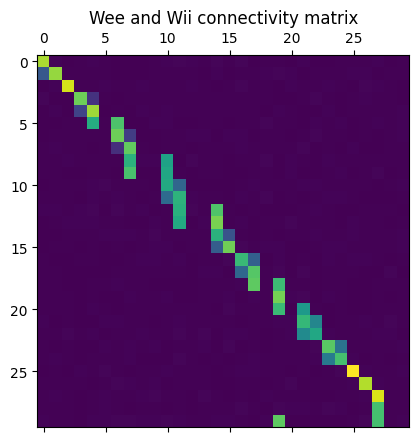

In [2]:

plt.matshow(loaded_wee_wii.detach().numpy() )
plt.title("Wee and Wii connectivity matrix")

## Functions

In [3]:
""" Plot HeatMap of firing rate function"""
def HeatMap(rE, rI, J=None, toshow = True):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)
    rE_df.index = rE_df.index + 1
    rI_df.index = rI_df.index + 1
    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time ms", "Time ms"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    if toshow:
        plt.show()

    else: 
        return fig, (axA, axB)
    #num_fig = random.randint(0, 1000)
    #fig.savefig(f'C:/Users/knzga/Documents/02_Computational Neuroscience Project/Image/OutputNetwork/Heatmap/Heatmap_{num_fig:0>3}.png')




# Make a dictionary a list if I want to access index! dictionary has no indexing (storage with keys)

def plot_connectivity_matrix(model_T, num_fig, Learning_Rate, n_epoch, limit = 2):
    labelsize = 10
    subtitle_size = 11
    #cmap = 'viridis'
    #cmap = 'plasma'
    cmap = 'magma'

    W_t = {}
    for name, par in model_T.named_parameters() : # enumerate(trained_model.parameters()):
        W_t[name] = par #getattr(trained_model, "wee)
        if name.startswith("J"):
            W_t.popitem()
            break
        
    #print(len(W_t))

    column = 0
    row = 1
    for i in range(len(W_t)):
        column += 1
        if column == limit +1:
            row +=1
            column = 0 

    if len(W_t) >=limit:
        column = limit
    else:
        column = len(W_t)
    
    ic(row, column)
    fig_m = plt.figure()
    # create figure window

    gs = gridspec.GridSpec(row, column)
    # Creates grid 'gs' of a rows and b columns

    """for r in range(row):
            for c in range(column):
                print(r, c)
    """
    ic(W_t.keys)
    W_list = list(W_t.items())
    
    if row > 0:
        index = 0
        for r in range(row):
            for c in range(column):
                name = W_list[index][0]
                w = W_list[index][1]
                ic(r, c, name)
                ax = plt.subplot(gs[r,c])
                ax0 = ax.matshow(w.detach().numpy() , cmap = cmap)
                # Adds subplot 'ax' in grid 'gs' at position [x,y]
                ax.set_ylabel(name)
                #ax.set_title(f"{name} trained", size = subtitle_size)
                #ax.figure.axes[index].tick_params(axis="both", labelsize= labelsize) 
                
                fig_m.colorbar(ax0,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)
                fig_m.add_subplot(ax)

                index +=1
                if index == len(W_t):
                    break
                else:
                    continue
                
    
    fig_m.suptitle(f'Connectivity matrix obtained with LR = {Learning_Rate}, Epochs = {n_epoch}')#, fontsize=16
    fig_m.savefig(f'C:/Users/knzga/Documents/02_Computational Neuroscience Project/Image/ConnectivityMatrix/connectivity_matrix_{Learning_Rate}_{n_epoch}_AfterTraining_{num_fig}.png')
    fig_m.tight_layout()
    fig_m.show()
    #plt.show()




""" Filters gauss and Dog and LoG"""
def gaussian_filter(s, N):
    pop = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2

def dog_filter(sOut, N):
    sIn = sOut / 30
    pop = np.arange(1, N + 1)
    gaussIn = np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog

def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig



def truncated_normal(N, mu=0., sigma= .1):
    sigma = 1/np.sqrt(N)
    lower, upper = 0., np.inf
    pop = np.arange(1, N + 1)
    
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    #x = np.linspace(0, size, size)

    return X.pdf(pop- pop[:, np.newaxis])#X.rvs(N)


def init_random_matrix(N, mu = 0.):

    lower, upper = 0., np.inf
    sigma = 1/np.sqrt(N)#random.randint(1, 30), random.uniform(0.1, 5)
    X = stats.truncnorm(
        (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    rnd_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)
    return rnd_matrix 


"""
 Normalization or transform to probability
"""

def make_it_proba(r_e):
    eps = torch.FloatTensor([sys.float_info.epsilon]) #torch.FloatTensor
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
 
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_r_e) #r_e_max.sum())
    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)


''' Classic Normalization
use:
#preprocessing.normalize(re_numpy, axis= 0)[20,:].sum()

or use:
'''
def normalize(x):
    N = (x - x.min()) / (x.max() - x.min())
    return N


"""
Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""
def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation

def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  
    return torch.tensor(y)

def replace_argmax(r):
    # along some dimension (e.g., the last dimension).
    indices = torch.arange(r.shape[-1]).to(r.device)
    return torch.gather(indices, dim=-1, index=torch.argmax(r, dim=-1)).max()




""" Target design: Get the expected stimuli and then create a matrix of 1 where stimuli 0 elsewhere"""

def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1) #consider replacing argmax by replace_argmax
    Xmax = torch.max(Xargmax)
    return Xmax

def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable
    
    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)# replace where function by relu functio which is differentiable
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d



""" 
Optimization function
Make a function which save parameters of trained model and upload the new model with the updated parameters
"""

def model_with_saved_trained_param(old_model, optimizer, Model, param, sim, dicJ):
    # or to save the parameters only
    torch.save(old_model.state_dict(),"Old_model_optimized_parameters.pth")
    torch.save(optimizer.state_dict(),"optimizer_optimized_parameters.pth")
    #load these parameters in a new model instance
    new_mymodel = Model(param, sim, dicJ)
    new_mymodel.load_state_dict(torch.load("Old_model_optimized_parameters.pth")) 
    optimizer.load_state_dict(torch.load('optimizer_optimized_parameters.pth'))

    #print(optimizer.param_groups[0]['params'])
    if old_model.Jee == new_mymodel.Jee:
        print("it works")
    print("old model Jee:",old_model.Jee,"new model Jee:", new_mymodel.Jee)
    #print(optimizer.param_groups)
    #print(optimizer.state)
    return new_mymodel, optimizer


def load_weights(newmodel, modelpath): #string
        if '.pt' not in modelpath:
            modelpath += '.pt'      
        newmodel.load_state_dict(torch.load(modelpath))
        #new_mymodel = Model(param, sim, model.state_dict())
        return newmodel #, newmodel.state_dict() to access the param
    
def save_weights(oldmodel, modelpath, epoch=None):  #string
    if '.pt' not in modelpath:
            modelpath += '.pt'
    torch.save(oldmodel.state_dict(), modelpath)

    

"""
Model evaluation

function wich test the accuracy of a model with new parameters compared to expected results + loss values for every samples
"""
def test_model(model, test_dataloader, loss_f):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            # Calculate output
            Y_prediction, _, dredt, dridt = model(x_test[0])
            #Y_prediction_prob = make_it_proba(Y_prediction)

            # Calculate loss
            #loss = loss_f(Y_prediction_prob, y_test[0], dredt, dridt)
            loss = loss_f(Y_prediction, y_test[0], dredt, dridt)

            # Accuracy
            predictions = Y_prediction.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            #predictions = Y_prediction_prob.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            correct_predictions += (predictions == y_test[0]).sum().item() # calculates the number of correct predictions by comparing the rounded predictions with the true labels (y_test). It sums up the correct predictions over the batch.
            total_samples += y_test[0].numel() # adds the total number of samples/item in the current batch to the overall count.

            test_loss += loss.item()

    accuracy = correct_predictions / total_samples
    average_loss = test_loss / len(test_dataloader)

    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {average_loss:.4f}')
    return accuracy, average_loss



""" 
LOSS
"""

def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)


#for l2 reg with w params
def sum_relu(w):
      return torch.sum(F.relu(-w))


""" 
Run simulation over batchXtime
"""

def run_model_across_batch(Input, len_sim, model_instance):
    count = 0 
    P0 = torch.zeros_like(Input)  
    I0 = torch.zeros_like(Input)
    dPdt = torch.zeros_like(Input)  
    model_instance.initiate_state()

    for i in range(Input.shape[0]):
            count +=1
            P0[i,:], I0[i,:], dPdt[i,:], dridt, ampa, gaba = model_instance.forward(Input[int(i),:])#.item()
            if count == len_sim: #train_IN.shape[1]: #if we end the simulation time and go to the next batch
                count = 0
                model_instance.initiate_state()

    return P0, I0, dPdt





""" 
Plot Normalised predictions
"""
def plot_normalized_plot(P0, Ptrained, t, legend = None): #legend = list of 2 strings 
    P0_np = np.array(P0.detach().numpy())
    PT_np = np.array(Ptrained.detach().numpy())

    P0_norm = preprocessing.normalize(P0_np, axis= 1) 
    PT_norm = preprocessing.normalize(PT_np, axis= 1) 
    if legend is None:
        plt.plot(np.arange(P0_norm.shape[1]), P0_norm[t,:], label = f"{t}ms, untrained")
        plt.plot(np.arange(PT_norm.shape[1]), PT_norm[t,:], label = f"{t}ms, trained")
    else:
        plt.plot(np.arange(P0_norm.shape[1]), P0_norm[t,:], label = f"{t}ms," + legend[0])
        plt.plot(np.arange(PT_norm.shape[1]), PT_norm[t,:], label = f"{t}ms," + legend[1])



## Class

### Simple Class

In [4]:

# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°
    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']
    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    #°°° Hard encode these parameters °°°
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    #Jes, Jsi = pars['Jes'], pars['Jsi']
    #Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    #N=20, sIn=.1, sOut=3., sEI=.2

    def __init__(self, sEI=.2, sIn=.1, sOut=3., N=30):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("Time step of the simulation (dt):", self.dt, "  Duration of simulation (T):", self.T,"s",
              "  Length of the time frame (Lt):", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=0, dur=0.05):#ISI=0.5, dur=0.2): #ISI=1, dur=0.2   # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0
        self.N = param.N

        # Instantaneous frequency
        #f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f: #+2 to not lose dimension ! becareful! 
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt)+2, 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
    
        f_stim = fx_array # np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1
      
    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, f_stim=None, InMax=None, In0=None):
        paramf = np.arange(1, self.N+1)
        
        #mask the ground truth f_stim by a gaussian function
        w = np.exp(-(((paramf) - (self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N
        #ic((w).shape)
        #if I want to normalize w:
        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N +1, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))
        
        In_short = In
        range_sim = np.arange(1, In_short.shape[0] + 1)
        len_sim = len(range_sim)
        self.In = In_short
        self.w = w
        self.sigmaIn = sigmaIn

        return In_short, range_sim, len_sim ,w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI,"s","  Size In", self.In.shape, "Size w:",
              self.w.shape, "  f_stim = total length simulation:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




#  °°° Data preparation °°°
        
""" 
1- create a big dataset for every stimuli input. In = X stimulus
2- Split In / X into train and test dataset: Split 70% into train dataset and 30% into test dataset
3- get expected Y / Target
4- Create the DataLoader merging Xtrain_tensor and Ytrain_tensor (Input and Target)
 """

class Batch:
    def __init__(self, param, simu,len_sim):
     # 1  \\\\\\\\\\\ BIG Bottom up sensory input
        self.N_short = param.N # - 6
        self.IN= torch.zeros(len_sim, self.N_short ,self.N_short)
        self.get_sensory_input(param,simu)
        

    def get_sensory_input(self, param, simu):
        for i in range(0, self.N_short):
            index = i+1
            st = Stim(param,simu, dur=simu.T,f =[index], ISI=0) 
            In, _,_,_,_ =st.sensoryInput(param, simu, sigmaIn = 2.)
            self.IN[:,:, i] = torch.tensor(In)
            #sti = torch.tensor(In).float()

    # 2
    def train_test_dataset(self):
        #create a random list containing each of our stimuli types
        num_stimuli = self.IN.shape[2]
        rand_idx = np.arange(0, num_stimuli)
        rng = np.random.default_rng(1245)
        rng.shuffle(rand_idx)

        # split this random list into test and train index. and filter the IN with those indexes
        val_split_index = int(np.floor(0.7 * num_stimuli))
        test_idx, train_idx = rand_idx[val_split_index:], rand_idx[:val_split_index]
        
        train_IN = self.IN[:,:, train_idx].permute(2,0,1)
        test_IN = self.IN[:,:, test_idx].permute(2,0,1)

        return train_IN, test_IN

    # 3
    def get_Targets(self, Inputs):
        Targets = torch.zeros_like(Inputs)
        num_stimuli, _,_ = Inputs.shape
        for stim_idx in range(num_stimuli):
            Targets[stim_idx,:,:] = get_expected_Y_relu(Inputs[stim_idx,:,:])
        return Targets

    # 4
    def create_dataloader(self, Inputs, Targets):   
        dataset = TensorDataset(Inputs, Targets)
        return DataLoader(dataset, batch_size=1, shuffle = True) #one sample per batch

    # 5
    def preprocess_data(self):

        train_IN, test_IN = self.train_test_dataset()
        #get expected target for every stimuli type /batch
        train_Targets = self.get_Targets(train_IN) 
        test_Targets = self.get_Targets(test_IN) 

        train_dataloader = self.create_dataloader(train_IN, train_Targets)
        test_dataloader = self.create_dataloader(test_IN, test_Targets)
        return train_dataloader, train_Targets, train_IN, test_dataloader, test_Targets, test_IN
    
    #6
    def safety_plot(self, train_IN, train_Targets):  
        X_proba = make_it_proba(train_IN[4,:,:])
        Y = train_Targets[4,:,:]
        N = X_proba.shape[1]      
        t=48
        plt.plot(torch.arange(1, N+1), X_proba[t,:], label= f"Proba Input at t={t}") #not in proba
        plt.plot(torch.arange(1, N+1), Y.detach().numpy()[t,:], label = f"target at t={t}") #in proba
        plt.legend()



class Batch_for_NLLL:
    def __init__(self, IN):
        self.Input =  IN
        BatchxTime = self.Input.shape[0]*  self.Input.shape[1]
        self.Target_index = torch.zeros(BatchxTime)
        self.make_Target_index(self.Input)
        
        self.Input_reshaped = self.Input.reshape(self.Input.shape[0]*  self.Input.shape[1], self.Input.shape[2])
    
    def make_Target_index(self, Input):
        time_stim = 0
        for batch in range(0, Input.shape[0]):
            for time in range(0, Input.shape[1]):
                self.Target_index[time + time_stim] = get_stimuli_input(Input[batch,:,:]).item()
            time_stim += Input.shape[1]



# °°° Stopping criterion for the loss °°°

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("--- loss is not improving - training will stop ---")
                return True
        return False
        


### Classs Model

In [5]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class Model(nn.Module):
    def __init__(self, param, sim, dicJ, In):
        super(Model, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = sim.dt #torch.tensor(1e-4) #
        self.N = In.shape[1]#param.N - 6 #20
        self.taue = self.taui = torch.tensor(param.taue) #torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(param.ae)# 18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(param.be) #-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(param.hme)#78.67)
        self.ai = torch.tensor(param.ai)#21.97)
        self.bi = torch.tensor(param.bi)#-4.81)
        self.hmi = torch.tensor(param.hmi)#125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)


        with open(file_name, "rb") as file:
            loaded_wee_wii = pickle.load(file)
        
        self.wii = self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)# torch.tensor(loaded_wee_wii.detach().numpy() , dtype=torch.float32)#self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # torch.tensor(loaded_wee_wii.detach().numpy() , dtype=torch.float32) #!!! N = 30  ## dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wee =  self.wee = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  #torch.tensor(loaded_wee_wii.detach().numpy() , dtype=torch.float32)#self.wee = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) #torch.tensor(loaded_wee_wii.detach().numpy() , dtype=torch.float32) #

        #wee_o = init_random_matrix(N=self.N)
        #self.wee = nn.Parameter(torch.tensor(wee_o, requires_grad = True, dtype = torch.float32)) 
        #self.wii = nn.Parameter(torch.tensor(wii_o, requires_grad = True, dtype = torch.float32)) 

        # Example usage for w0 initialization 
        #self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        #self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)         
        wei_o = init_random_matrix(N=self.N)
        wie_o = init_random_matrix(N=self.N)
        
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.wei = nn.Parameter(torch.tensor(wei_o, requires_grad = True, dtype = torch.float32))  
        self.wie = nn.Parameter(torch.tensor(wie_o, requires_grad = True, dtype = torch.float32))

        self.dicJ = dicJ #kwargs
        
        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True, dtype=torch.float64))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True, dtype=torch.float64))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True, dtype=torch.float64))

        #--- Initialize model variables here
    def initiate_state(self):
        self.prev_r_e = torch.zeros((self.N)) # torch.ones(self.N) shows more obvious results
        self.prev_r_i = torch.zeros((self.N))
        self.prev_s_ampa = torch.zeros((self.N))
        self.prev_s_gaba = torch.zeros((self.N))
        self.dr_e_dt = torch.zeros((self.N))
        self.dr_i_dt = torch.zeros((self.N))
        self.s_ampa = torch.tensor(0.)
        self.i_tot_e = torch.tensor(0.)
        self.i_tot_i = torch.tensor(0.)
		

    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
      
        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.
        mulaI = a * I_tot
        addB = mulaI + b
        expo = torch.exp(-addB)
        return hm / (1 + expo)
     

    def forward(self, In):
        #--- Compute values of interest
        #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
        s_gaba_wie = self.prev_s_gaba @ self.wie
        s_ampa_wei = self.prev_s_ampa @ self.wei
        s_gaba_wii = self.prev_s_gaba @ self.wii
        s_ampa_wee = self.prev_s_ampa @ self.wee
      
        self.i_tot_e = (self.Jee * s_ampa_wee) - (self.Jie * s_gaba_wie) + (self.Jin*  In)
        self.i_tot_i = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)

        phi_arr_e = self.phi(self.i_tot_e, self.ae, self.be, self.hme)
        phi_arr_i = self.phi(self.i_tot_i, self.ai, self.bi, self.hmi)

        self.dr_e_dt = (-self.prev_r_e + phi_arr_e) / self.taue
        self.dr_i_dt = (-self.prev_r_i + phi_arr_i) / self.taui

        r_e = self.prev_r_e+ self.dr_e_dt * self.dt
        r_i = self.prev_r_i + self.dr_i_dt * self.dt

        dS_amp_dt = (- self.prev_s_ampa / self.tauAMPA) + r_e
        s_ampa = self.prev_s_ampa+ dS_amp_dt * self.dt

        dS_gab_dt = (- self.prev_s_gaba / self.tauGABA) + r_i
        s_gaba = self.prev_s_gaba + dS_gab_dt * self.dt

        self.prev_r_e = r_e
        self.prev_r_i = r_i
        self.prev_s_ampa = s_ampa
        self.prev_s_gaba = s_gaba


        return self.prev_r_e, self.prev_r_i, self.dr_e_dt, self.dr_i_dt, self.prev_s_ampa, self.prev_s_gaba

### Data preparation: Call class and Create Batch (Input stimuli + target)

In [6]:
# \\\\ Parameters
param = Parameter(N = 30) # N=20

# \\\\ Simulation time: T in s  (2s before)
sim = Simulation(dt=1e-3,T=.0510) 
sim.printSim()

# \\\\ Bottom up sensory input
stimuli = Stim(param, sim, dur=sim.T, f=[8])
In, range_sim, len_sim, w, sigmaIn = stimuli.sensoryInput(param, sim, sigmaIn=2.) #2.
stimuli.printStim()

Time step of the simulation (dt): 0.001   Duration of simulation (T): 0.051 s   Length of the time frame (Lt): 51
frequence of stimulus f: [8]   ISI: 0 s   Size In (51, 30) Size w: (51, 30)   f_stim = total length simulation: (51, 1) sigmaIn: 2.0


In [7]:
"""wie_o = truncated_normal(N=param.N, mu = 0, sigma= 1/np.sqrt(param.N))
wie = nn.Parameter(torch.tensor(wie_o, requires_grad = True, dtype = torch.float64))
wie"""

'wie_o = truncated_normal(N=param.N, mu = 0, sigma= 1/np.sqrt(param.N))\nwie = nn.Parameter(torch.tensor(wie_o, requires_grad = True, dtype = torch.float64))\nwie'

### Check The initializations filters

In [8]:
"""def gaussian_filter(s, N):
    pop = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2

s = .6
pop = np.arange(1, param.N + 1)
n = 1 / (np.sqrt(2 * np.pi) * param.N * s)
gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))
gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW)) 

gaussW.shape
cmap ='viridis'
subtitle_size = 19
colorbar_size = 15
fig, ax = plt.subplots(1,2, figsize = (10, 5))
cax = ax[0].matshow(gaussW, cmap = cmap)#.tick_params(labelsize = 10)
# change the label size 
cax.figure.axes[0].tick_params(axis="both", labelsize=subtitle_size) 
ax[0].set_title("GaussW", size = subtitle_size +2)

cax2 = ax[1].matshow(gaussW2, cmap = cmap).figure.axes[1].tick_params(axis="both", labelsize=subtitle_size) 
#cax2.figure.axes[1].tick_params(axis="both", labelsize=subtitle_size) 
ax[1].set_title("GaussW2", size = subtitle_size+2)
fig.colorbar(cax,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=colorbar_size)  # those fraction and pad magically works to adapt every graph
fig.colorbar(cax2,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=colorbar_size) 
#clb=plt.colorbar()
#clb.ax.tick_params(labelsize=8) 
plt.show"""

'def gaussian_filter(s, N):\n    pop = np.arange(1, N + 1)\n    n = 1 / (np.sqrt(2 * np.pi) * N * s)\n    gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))\n    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1\n    return gaussW2\n\ns = .6\npop = np.arange(1, param.N + 1)\nn = 1 / (np.sqrt(2 * np.pi) * param.N * s)\ngaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))\ngaussW2 = gaussW / (.009 ** 2 / np.max(gaussW)) \n\ngaussW.shape\ncmap =\'viridis\'\nsubtitle_size = 19\ncolorbar_size = 15\nfig, ax = plt.subplots(1,2, figsize = (10, 5))\ncax = ax[0].matshow(gaussW, cmap = cmap)#.tick_params(labelsize = 10)\n# change the label size \ncax.figure.axes[0].tick_params(axis="both", labelsize=subtitle_size) \nax[0].set_title("GaussW", size = subtitle_size +2)\n\ncax2 = ax[1].matshow(gaussW2, cmap = cmap).figure.axes[1].tick_params(axis="both", labelsize=subtitle_size) \n#cax2.figure.axes[1].tick_params(axis="both", labelsize=subtitle_size) \nax[1].set_t

Check the random initializtation:

In [9]:
"""lower, upper = 0., np.inf
mu, sigma = 0, 1/np.sqrt(param.N)#random.randint(1, 30), random.uniform(0.1, 5)
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

matrix1 = np.zeros((param.N, param.N))
for i in range(param.N):
    for j in range(param.N):
        matrix1[i][j] = np.random.uniform(low=0.0, high=1.0, size=None) #X.rvs(1)

plt.matshow(matrix1)



matrix = np.zeros((param.N, param.N))
for i in range(param.N):
    for j in range(param.N):
        matrix[i][j] = X.rvs(1)

plt.matshow(matrix)
"""

'lower, upper = 0., np.inf\nmu, sigma = 0, 1/np.sqrt(param.N)#random.randint(1, 30), random.uniform(0.1, 5)\nX = stats.truncnorm(\n    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)\n\nmatrix1 = np.zeros((param.N, param.N))\nfor i in range(param.N):\n    for j in range(param.N):\n        matrix1[i][j] = np.random.uniform(low=0.0, high=1.0, size=None) #X.rvs(1)\n\nplt.matshow(matrix1)\n\n\n\nmatrix = np.zeros((param.N, param.N))\nfor i in range(param.N):\n    for j in range(param.N):\n        matrix[i][j] = X.rvs(1)\n\nplt.matshow(matrix)\n'

In [10]:
batch_instance = Batch(param=param, simu=sim, len_sim = sim.Lt)
train_dataloader, train_Targets, train_IN, test_dataloader, test_Targets, test_IN = batch_instance.preprocess_data()
#batch_instance.safety_plot(train_IN,train_Targets)
#batch_instance.IN[:,3:-3,3:-3].shape

batch_instance_NLLL = Batch_for_NLLL(train_IN)
Target_idx_NLLL = batch_instance_NLLL.Target_index
Input_NLLL =batch_instance_NLLL.Input_reshaped

#ic(Target_idx_NLLL.shape, Input_NLLL.shape, train_IN.shape)


In [11]:
# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J_list = list(J1.keys())
print(J1['Jee'], J_list)
model = Model(param=param, sim=sim, dicJ=J1, In = In)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

P0, I0, dP0dt = run_model_across_batch(Input_NLLL, len_sim, model)
#P0 = P0[:,3:param.N-3] # remove the 3 last populations and 3 firsts one 
#I0 = I0[:,3:param.N-3]
#Input_NLLL_short = Input_NLLL[:,3:-3]


0.072 ['Jee', 'Jei', 'Jie', 'Jii', 'Jin']


C:\Users\knzga\AppData\Local\Temp\ipykernel_11792\3422460121.py:171: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)


### Get Inputs and Target without pitch [:3, :-3]

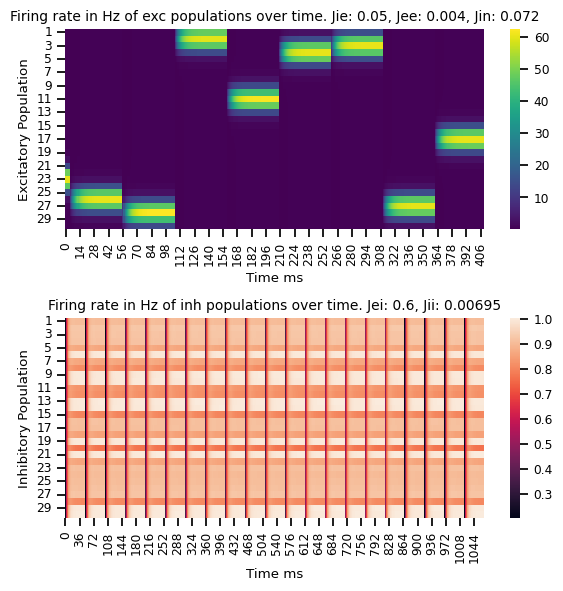

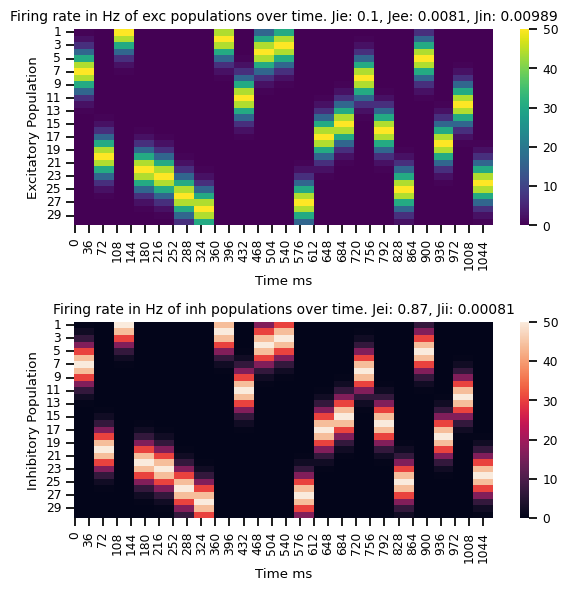

In [12]:
#50
HeatMap(P0[250:660,:].detach().numpy(), I0.detach().numpy(), J1)
HeatMap(Input_NLLL.detach().numpy(), Input_NLLL.detach().numpy())

## loosss

In [13]:
train_IN.shape
#3/ L2 regu term
"""l2_reg_coef=0.0001
l2_reg = 0.0
for param in mymodel.parameters():
    l2_reg += torch.sum(param**2)

#L2_term = l2_reg * l2_reg_coef
"""

'l2_reg_coef=0.0001\nl2_reg = 0.0\nfor param in mymodel.parameters():\n    l2_reg += torch.sum(param**2)\n\n#L2_term = l2_reg * l2_reg_coef\n'

In [20]:
def custom_loss_(Prediction,Inhib, Target, derivativeE):
  #1/ Proba term
  criterion = torch.nn.NLLLoss()
  P2 = make_it_proba(Prediction) #
  loss_norm = criterion(P2, Target.long())

  #2/ derivative good 
  #loss_derivative = torch.zeros_like(Target)
  eps = torch.FloatTensor([sys.float_info.epsilon]) 
  Target_idx_np = (Target).numpy().astype(int)
  #loss_derivative = torch.zeros(train_IN.shape[0])
  loss_derivative = torch.zeros_like(Target)
  

  # L1
  hyperactvity_penalty = torch.zeros(train_IN.shape[0])
  laziness_penalty = torch.zeros(train_IN.shape[0])
  
  count = 0
  i2 = 0
  start = 0
  stop = (len_sim)
  for i, sti_idx in enumerate(Target_idx_np):
      count +=1
      if count == stop:
          time_idx = slice(start, stop)
          #loss_derivative[i2] = - F.softplus(derivativeE[time_idx,sti_idx] ).mean() + F.softplus(derivativeE[time_idx,:sti_idx]).mean() + F.softplus(derivativeE[time_idx,(sti_idx+1):]).mean()
          
          
          if torch.max(Prediction[time_idx,sti_idx]) > 60.: #60
              hyperactvity_penalty[i2] = torch.sum((Prediction[time_idx, sti_idx]**2)) #torch.clamp(r_e[:, 7], max=10.0
              #ic(hyperactvity_penalty[i2])
          else:
              hyperactvity_penalty[i2] = 0
             #ic(hyperactvity_penalty[i2])
              
          if torch.max(Prediction[time_idx,sti_idx]) < 10.: #60
              laziness_penalty[i2] = torch.sum(1 / torch.clamp(Prediction[time_idx, sti_idx]**2, min = eps)) #torch.clamp(r_e[:, 7], max=10.0

          else:
              laziness_penalty[i2] = 0
              #activity_threshold = 10.0  # Adjust as needed
              # Calculate low_activity_penalty using the inverse of the activity
              #low_activity_penalty[i2] = torch.sum(1.0 / torch.clamp(Prediction[time_idx, sti_idx], min=activity_threshold))

              #ic(hyperactvity_penalty[i2])
             #ic(hyperactvity_penalty[i2])
          
          i2 += 1
          start = stop
          stop += len_sim
          """
          """
  
  """len_sim_test = len_sim
  count = 0
  start = 0
  i2 = 0
  for i, sti_idx in enumerate(Target_idx_np):
      count += 1
      if count == len_sim_test:
          # time_ind = slice(count, len_sim_test)
          loss_derivative[i2] = - F.softplus(derivativeE[start:len_sim_test,sti_idx] ).sum() + F.softplus(derivativeE[start:len_sim_test,:sti_idx]).sum() + F.softplus(derivativeE[start:len_sim_test,(sti_idx+1):]).sum()
          #ic(loss_derivative[i])
          start = count
          len_sim_test += len_sim
          #ic(start, len_sim_test)
          i2 += 1"""

  len_sim_test = len_sim
  count = 0
  start = 0
  for i, sti_idx in enumerate(Target_idx_np):
    count += 1
    if count == len_sim_test:
        loss_derivative[i] = - F.softplus(derivativeE[start:len_sim_test,sti_idx] ).sum() + F.softplus(derivativeE[start:len_sim_test,:sti_idx]).sum() + F.softplus(derivativeE[start:len_sim_test,(sti_idx+1):]).sum()
        #ic(loss_derivative[i])
        start = count
        len_sim_test += len_sim_test
  """
  for i, sti_idx in enumerate(Target_idx_np):
    loss_derivative[i] = - F.softplus(derivativeE[:,sti_idx] ).sum() + F.softplus(derivativeE[:,:sti_idx]).sum() + F.softplus(derivativeE[:,(sti_idx+1):]).sum()
  """
  loss_derivative_term = loss_derivative.mean()
  coef_derivative = 1E-6 #1E-6 #0.00001
  loss_derivative_term = coef_derivative * loss_derivative_term
  
  hyperactvity_penalty_term = hyperactvity_penalty.mean()
  hyperactvity_penalty_coef= 1E-7#1E-6 1E-6
  hyperactvity_penalty_term = hyperactvity_penalty_term * hyperactvity_penalty_coef
  laziness_penalty = (laziness_penalty.sum() * 0.01)

  #4/ Constraint ws
  W = {}
  for name, par in model.named_parameters() : # enumerate(trained_model.parameters()):
        W[name] = par #getattr(trained_model, "wee)
        if name.startswith("J"):
            W.popitem()
            break

  be_positive = 0
   
  #be_positive = torch.sum(torch.nn.functional.relu(-model.wie))
  W_l = list(W.items())
  for i in range(len(W_l)):
      be_positive += sum_relu(W_l[i][1]) #torch.sum(F.relu(-wie)) +torch.sum(F.relu(- wei)) + torch.sum(F.relu(- win))#""""""

  # L1 reg/ sparse coding 
  sparse_coding_coef = 1E-3 # Adjust the coefficient based on the desired strength
  tau_s = 1#0.001
  #sparse_coding_term = sparse_coding_coef * torch.sum(torch.log(1 + (Inhib**2 / tau_s)))#torch.sum(torch.abs(Inhib))
  sparse_coding_wei = sparse_coding_coef *  torch.sum(torch.log(1 + (W["wei"]**2 / tau_s)))#torch.sum(torch.abs(W["wei"])) #)#torch.sum(torch.abs(Inhib))
  sparse_coding_wie = sparse_coding_coef * torch.sum(torch.log(1 + (W["wie"]**2 / tau_s))) #torch.sum(torch.abs(W["wie"]))##torch.sum(torch.abs(Inhib))
  #sparse_coding_wii = torch.sum(torch.log(1 + (W["wii"]**2 / tau_s))) #torch.sum(torch.abs(W["wii"]))# #torch.sum(torch.abs(Inhib))
  #sparse_coding_wee = torch.sum(torch.log(1 + (W["wee"]**2 / tau_s))) #torch.sum(torch.abs(W["wee"]))# #torch.sum(torch.abs(Inhib))
  
  sparse_coding_term =  (sparse_coding_wei + sparse_coding_wie) # + sparse_coding_wii+ sparse_coding_wee +   sparse_coding_coef *
  Cost = loss_norm + loss_derivative_term + (be_positive *10) + hyperactvity_penalty_term + laziness_penalty + sparse_coding_term #+ activity_regularization
  #ic(loss_norm, loss_derivative_term, be_positive,hyperactvity_penalty_term, laziness_penalty)#loss_derivative_term, hyperactvity_penalty_term)
  return Cost

In [15]:
train_Targets_reshaped = train_Targets.reshape(train_Targets.shape[0]*  train_Targets.shape[1], train_Targets.shape[2])

def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)

## Optimization

In [16]:
train_Targets.shape

torch.Size([21, 51, 30])

In [17]:
class run_optimization:
    def __init__(self, model, Input, T, modelpath ,opti_name = "Adam" ,num_epoch =20, learning_rate =0.0001):
        criterion = torch.nn.NLLLoss()
        logsoft = nn.LogSoftmax(dim=1)
        self.early_stopper = EarlyStopper(patience=15, min_delta=2)#3

        self.losses = torch.zeros(num_epoch)

        if opti_name =="Adam":
            self.optimizer = optim.Adam(model.parameters(),
                      lr=learning_rate)
        elif opti_name == "SGD":
            self.optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate, weight_decay = 0.001)
        
        self.run(criterion, logsoft, model, Input, T, modelpath, num_epoch,learning_rate)

    def run(self, criterion, logsoft, model, Input, T, modelpath, num_epoch, learning_rate): 
        model.initiate_state()
        model.train()
        for epoch in range(num_epoch):
            model.initiate_state()
            self.optimizer.zero_grad()  
            P = torch.zeros(Input.shape)   
            I = torch.zeros(Input.shape) 
            dPdt = torch.zeros_like(Input)  

            count = 0
            for i, b in enumerate(T):
                count +=1
                P[i,:], I[i,:], dPdt[i,:], dridt, ampa, gaba = model(Input[int(i),:])
                if count == len_sim: #train_IN.shape[1]: #if we end the simulation time and go to the next batch
                    count = 0
                    model.initiate_state()

            #P2 = logsoft(P)
            #P2 = make_it_proba(P)
            #loss = criterion(P2, T.long())  #loss = criterion(P, T.long()) # #criterion(P2, T.long()) # #loss = easyLoss(P2, train_Targets_reshaped) #loss = custom_loss_(P, Target_idx_NLLL, dPdt)
            loss = custom_loss_(P, I, Target_idx_NLLL, dPdt)

            loss.backward()
            self.optimizer.step()
            
            ic(torch.max(P))#, torch.min(P),torch.mean(P))
            #ic(torch.max(P2), torch.min(P2), torch.mean(P2))
            
            if self.early_stopper.early_stop(loss):  
                break
            

            self.losses[epoch] = loss
            print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}, Learning rate:{learning_rate}')#.item()
            #for par in model.parameters():
                #ic(par.grad)
        r = np.round(np.random.rand(),1)
        g = np.round(np.random.rand(),1)
        b = np.round(np.random.rand(),1)
        color_l = [r,g,b]
        plt.plot(np.arange(self.losses.shape[0]), self.losses.detach().numpy(), 'bo', color = color_l, label = f'Loss over {num_epoch}epochs with LR = {learning_rate}')
        plt.legend()
        plt.show()
        if '.pth' not in modelpath:
            modelpath += '.pth' #alejandros has pt
        plt.plot(np.arange(P.shape[1]), P[50,:].detach().numpy(), color = color_l, label = f'firing rate with {learning_rate}')
        plt.legend()
        plt.show()
        HeatMap(P[:50,:].detach().numpy(), I[:50,:].detach().numpy(), J1)
        save_weights(model, modelpath)
        self.color_list = color_l

## RUn training

In [ ]:
"""Jbad = {'Jee': 0.04, 'Jei': 0.001, 'Jie': 0.01, 'Jii': 0.4, 'Jin': .00595}
BadModel = Model(param, sim, Jbad)

optim_bad = run_optimization(BadModel, Input_NLLL, Target_idx_NLLL, "Optimized_bad" ,opti_name = "Adam" ,num_epoch =100, learning_rate =0.0001)
"""

LRs =[1E-2]#, 1E-3, 2E-3,5E-3 ,8E-3,7E-3]#[8E-3]# [1E-2, 9E-3 ,8E-3,7E-3]#, 1E-6 , 1E-7#0.01, #0.5, 0.1, 0.05, 0.01,  0.001,#0.0001, 
optim_list = []
for i, lr in enumerate(LRs):
    model_new = Model(param,sim, J1, Input_NLLL)
    result = run_optimization(model_new, Input_NLLL, Target_idx_NLLL, "Optimized_good_lr_" + f"{lr}"  ,opti_name = "Adam" ,num_epoch = 100, learning_rate = lr)
    optim_list.append(result)


In [ ]:
optim_list =optim_list

for i in range(0, len(optim_list)):
    """    r = np.round(np.random.rand(),1)
        g = np.round(np.random.rand(),1)
        b = np.round(np.random.rand(),1)"""
    color_l = optim_list[i].color_list# [r,g,b]
    plt.plot(np.arange(optim_list[i].losses.shape[0]), optim_list[i].losses.detach().numpy(), 'bo', color = color_l, label = f'Loss for {LRs[i]}')

plt.legend()
plt.title(f"Loss over {optim_list[i].losses.shape[0]} epochs")

In [ ]:
pop = np.arange(param.N)
subtitle_size = 20
lower, upper = 0., np.inf
mu, sigma = 0, 1/np.sqrt(param.N)#random.randint(1, 30), random.uniform(0.1, 5)
wie = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
wie_pdf =wie.pdf(pop- pop[:, np.newaxis])

cmap = 'magma'

wie_train = list(model.parameters())[0].detach().numpy()
fig2, ax_t = plt.subplots(1,2, figsize = (10, 5))
ax1 = ax_t[0].matshow(wie_train, cmap = cmap)
ax1.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax_t[0].set_title("wie trained", size = subtitle_size-4)

ax2 = ax_t[1].matshow(wie_pdf, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax2.figure.axes[1].tick_params(axis="both", labelsize= 10) 
ax_t[1].set_title(f"truncated pdf: wie not trained, sigma ={sigma}", size = subtitle_size-4)
fig2.colorbar(ax1,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig2.colorbar(ax2,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
plt.show


In [ ]:
plt.plot(np.arange(30), wie_train[10], label = "wie trained")
plt.plot(np.arange(30), wie_pdf[10], label = "initial wie")
plt.legend()

## Test new Learning rate

C:\Users\knzga\AppData\Local\Temp\ipykernel_11792\3422460121.py:171: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_matrix[i][j] = X.rvs(1)# np.random.uniform(low=0.0, high=1.0, size=1) #X.rvs(1)


Epoch [1/610], Loss: -0.24544671177864075
Epoch [2/610], Loss: -0.17879796028137207
Epoch [3/610], Loss: -0.23554353415966034
Epoch [4/610], Loss: -0.10213875770568848
Epoch [5/610], Loss: -0.1482398808002472
Epoch [6/610], Loss: -0.1944853961467743
Epoch [7/610], Loss: -0.18489018082618713
Epoch [8/610], Loss: -0.20485368371009827
Epoch [9/610], Loss: -0.22115273773670197
Epoch [10/610], Loss: -0.20561939477920532
Epoch [11/610], Loss: -0.1637963056564331
Epoch [12/610], Loss: -0.2308071255683899
Epoch [13/610], Loss: -0.17912262678146362
Epoch [14/610], Loss: -0.22480501234531403
Epoch [15/610], Loss: -0.23667702078819275
Epoch [16/610], Loss: -0.21886682510375977
Epoch [17/610], Loss: -0.22938136756420135
Epoch [18/610], Loss: -0.23993799090385437
Epoch [19/610], Loss: -0.23345117270946503
Epoch [20/610], Loss: -0.2517163157463074
Epoch [21/610], Loss: -0.2647733986377716
Epoch [22/610], Loss: -0.2622106671333313
Epoch [23/610], Loss: -0.27282801270484924
Epoch [24/610], Loss: -0.24

C:\Users\knzga\AppData\Local\Temp\ipykernel_11792\1813086757.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', color = color_l, label = f'learning rate = {learning_rate}')


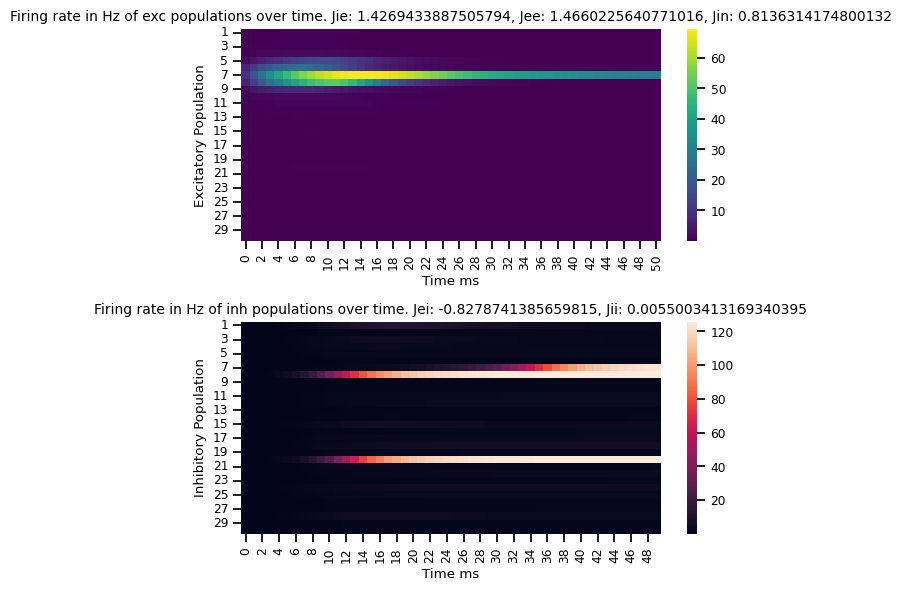

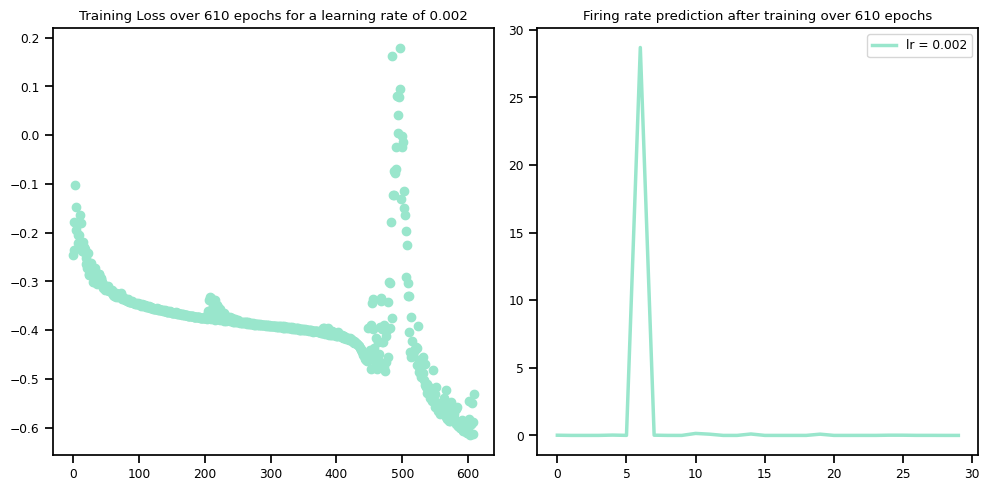

ic| row: 1, column: 2
ic| W_t.keys: <built-in method keys of dict object at 0x00000142F0EB5080>
ic| r: 0, c: 0, name: 'wei'
ic| r: 0, c: 1, name: 'wie'
C:\Users\knzga\AppData\Local\Temp\ipykernel_11792\3422460121.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_m.show()


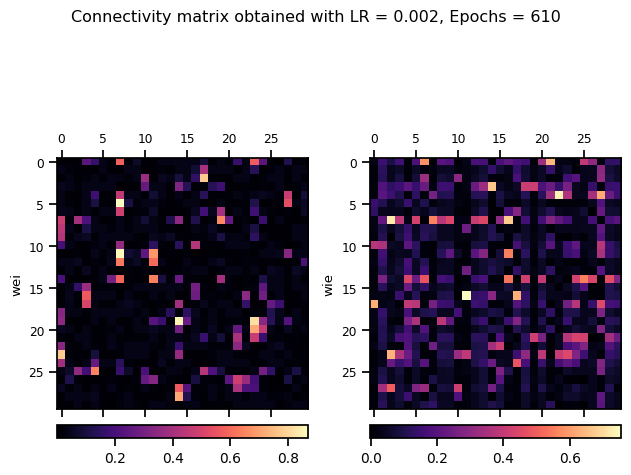

In [21]:
model = Model(param=param, sim=sim, dicJ= J1, In = Input_NLLL)
model.initiate_state()
num_epoch = 610
losses = torch.zeros(num_epoch)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.NLLLoss()
logsoft = nn.LogSoftmax(dim=1)
learning_rate = 0.002 #0.001 #0.009#0.01
early_stopper = EarlyStopper(patience=20, min_delta=2)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

"""optim.SGD(model.parameters(),
                      lr=0.0001, weight_decay = 0.001) 
                       """


T = Target_idx_NLLL 
Input = Input_NLLL 


model.train()
for epoch in range(num_epoch):
    model.initiate_state()
    optimizer.zero_grad()  
    P = torch.zeros(Input.shape)   
    I = torch.zeros(Input.shape) 
    dPdt = torch.zeros_like(Input)  

    count = 0
    for i, b in enumerate(T):
        count +=1
        P[i,:], I[i,:], dPdt[i,:], dridt, ampa, gaba = model(Input[int(i),:])
        if count == train_IN.shape[1]: #if we end the simulation time and go to the next batch
            count = 0
            model.initiate_state()
    
    
    #P2 =F.softmax(P, dim=1) # make_it_proba(P)   #P2 = F.softmax(P, dim=1) #P2 = logsoft(P)#.t()
    #P2 = logsoft(P)
    P2 = make_it_proba(P)
    #loss = easyLoss(P2, train_Targets_reshaped)
    #loss = criterion(P2, T.long())  #loss = criterion(P, T.long()) # #criterion(P2, T.long()) # 
    loss = custom_loss_(P, I,T, dPdt)
    loss.backward()
    optimizer.step()
    #ic(torch.max(P))
    #ic(torch.max(P), torch.min(P),torch.mean(P))
    #ic(torch.max(P2), torch.min(P2), torch.mean(P2))

    if early_stopper.early_stop(loss):             
        break
    losses[epoch] = loss
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}')#.item()


r = np.round(np.random.rand(),1)
g = np.round(np.random.rand(),1)
b = np.round(np.random.rand(),1)
color_l = [r,g,b]

#ax = fig2.add_subplot(gs[0, :])
J2= {'Jee': model.Jee.detach().numpy(), 'Jei': model.Jei.detach().numpy(), 'Jie': model.Jie.detach().numpy(), 'Jii': model.Jii.detach().numpy(), 'Jin': model.Jin.detach().numpy()}

fig2, (axA, axB)  = HeatMap(P[:51,:].detach().numpy(), I[:50,:].detach().numpy(), J2, toshow = False)
#ax= axA #.plot(np.arange(0, 1e6, 1000))
num_fig = np.random.randint(0, 1000)
fig2.savefig(f'C:/Users/knzga/Documents/02_Computational Neuroscience Project/Image/OutputNetwork/Heatmap/Heatmap_Pred_{learning_rate}_{num_epoch}_{num_fig:0>3}.png')



fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(1,2, figure = fig)
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', color = color_l, label = f'learning rate = {learning_rate}')
ax1.set_title(f"Training Loss over {num_epoch} epochs for a learning rate of {learning_rate}")

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(np.arange(P.shape[1]), P[50,:].detach().numpy(), color = color_l, label = f"lr = {learning_rate}")
ax2.set_title( f'Firing rate prediction after training over {num_epoch} epochs')
#ax.set_ylabel('YLabel1 %d' % i)
#ax.set_xlabel('XLabel1 %d' % i)

fig.set_figheight(5)
fig.set_figwidth(10)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
plt.legend()
plt.show()


#ADD HEATPLOTHERE
fig.savefig(f'C:/Users/knzga/Documents/02_Computational Neuroscience Project/Image/OutputNetwork/Pred_losses_{learning_rate}_{num_epoch}_{num_fig:0>3}.png')
save_weights(model, "Optimized.pth")


plot_connectivity_matrix(model, "1", Learning_Rate= learning_rate, n_epoch= num_epoch)


#Saved a W variable

In [ ]:
W = {}
for name, par in model.named_parameters() : # enumerate(trained_model.parameters()):
    W[name] = par #getattr(trained_model, "wee)
    if name.startswith("J"):
        W.popitem()
        break

#wii_saved = W['wii']
wee_saved = W['wee']

# Save variable to file using pickle
file_name = "wee_wii_optimal.pkl"
with open(file_name, "wb") as file:
    pickle.dump(wee_saved, file)



In [ ]:
plot_connectivity_matrix(model, "1", Learning_Rate= learning_rate, n_epoch= num_epoch)


In [ ]:
plt.plot(np.arange(P[:51,:].detach().numpy().shape[0]), P[:51,6].detach().numpy(), label = "pop number 7")
plt.legend()

#### Evaluation of the new parameters:

In [ ]:
newModel = Model(param, sim, J1, In)#[:,3:-3])
trained_model = load_weights(newModel, "Optimized.pth")
#ic(trained_model.state_dict(), J1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#P_t, I_t, dP_tdt = run_model_across_batch(Input_NLLL[:,3:-3], len_sim, model)

In [ ]:
# Prediction before training
HeatMap(P0[:51,:].detach().numpy(), I0[0:50,:].detach().numpy(), J1)
# Prediction after training
J2= {'Jee': trained_model.Jee.detach().numpy(), 'Jei': trained_model.Jei.detach().numpy(), 'Jie': trained_model.Jie.detach().numpy(), 'Jii': trained_model.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(P[:51,:].detach().numpy(), I[:50,:].detach().numpy(), J2)



In [ ]:
"""

N = 30
#mu, sigma = 0, 1/np.sqrt(N)#random.randint(1, 30), random.uniform(0.1, 5)
wie_pdf = init_random_matrix(N) #truncated_normal(param.N, mu, sigma)
wei_pdf = init_random_matrix(N) #truncated_normal(param.N, mu, sigma)
win_pdf = init_random_matrix(N)
sigma = .7#param.sEI
sigmaSEI = .2 #for wie
wie_before = gaussian_filter(sigmaSEI, int(N))
wei_before = dog_filter(3.,N)
win_before= torch.tensor(np.eye(int(N)), dtype=torch.float32)

labelsize = 5
subtitle_size = 15
#cmap = 'viridis'
#cmap = 'plasma'
cmap = 'magma'

wie_train = trained_model.wie.detach().numpy() #list(model.parameters())[0].detach().numpy()
wei_train = trained_model.wei.detach().numpy() #list(model.parameters())[0].detach().numpy()
wii_train = trained_model.wii.detach().numpy()
wee_train = trained_model.wee.detach().numpy()

fig, ax_t = plt.subplots(3,3, figsize = (20, 10))
ax1 = ax_t[0][0].matshow(wie_train, cmap = cmap)
ax1.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax_t[0][0].set_title("new wie trained", size = subtitle_size-4)

ax2 = ax_t[0][1].matshow(wie_pdf, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax2.figure.axes[1].tick_params(axis="both", labelsize= 10) 
 # np.round(sigma, 3)
ax_t[0][1].set_title(f"new wie not trained", size = subtitle_size-4)

ax3 = ax_t[0][2].matshow(wie_before, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax3.figure.axes[2].tick_params(axis="both", labelsize= 10) 
ax_t[0][2].set_title(f"old wie, sigma ={sigmaSEI}", size = subtitle_size-4)

ax4 = ax_t[1][0].matshow(wei_train, cmap = cmap)
ax4.figure.axes[3].tick_params(axis="both", labelsize= 10) 
ax_t[1][0].set_title("new wei trained", size = subtitle_size-4)

ax5 = ax_t[1][1].matshow(wei_pdf, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax5.figure.axes[4].tick_params(axis="both", labelsize= 10) 
 # np.round(sigma, 3)
ax_t[1][1].set_title(f"new wei not trained", size = subtitle_size-4)

ax6 = ax_t[1][2].matshow(wei_before, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax6.figure.axes[5].tick_params(axis="both", labelsize= 10) 
ax_t[1][2].set_title(f"old wei, sigma ={param.sOut}", size = subtitle_size-4)


ax7 = ax_t[2][0].matshow(wii_train, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax7.figure.axes[6].tick_params(axis="both", labelsize= 10) 
ax_t[2][0].set_title(f"new wii trained", size = subtitle_size-4)

ax8 = ax_t[2][1].matshow(wee_train, cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax8.figure.axes[7].tick_params(axis="both", labelsize= 10) 
ax_t[2][1].set_title(f"new wee trained", size = subtitle_size-4)

ax9 = ax_t[2][2].matshow(trained_model.wes.detach().numpy(), cmap = cmap)#.figure.axes[0].tick_params(axis="both", labelsize= 10) 
ax9.figure.axes[8].tick_params(axis="both", labelsize= 10) 
ax_t[2][2].set_title(f"win", size = subtitle_size-4)


fig.colorbar(ax1,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax2,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax3,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax4,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax5,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax6,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax7,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax8,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph
fig.colorbar(ax9,fraction=0.046, pad=0.04, orientation='horizontal').ax.tick_params(labelsize=10)  # those fraction and pad magically works to adapt every graph

fig.savefig(f'C:/Users/knzga/Documents/02_Computational Neuroscience Project/Image/ConnectivityMatrix/connectivity_matrix_{learning_rate}_{num_epoch}_AfterTraining.png')

plt.tight_layout()
plt.show
"""

In [ ]:
popu = 8
plt.plot(np.arange(30), wie_train[popu], label = "new wie trained")
plt.plot(np.arange(30), wei_train[popu], label = "new wei trained")
#plt.plot(np.arange(30), wie_before[popu], label = "old wie")#
plt.plot(np.arange(30), wee_train[popu], label = "new wee trained")
#plt.plot(np.arange(30), wei_before[popu], label = "old wei")#wei_train
#plt.plot(np.arange(30), wie_pdf[popu], label = "new wie untrained")
plt.title("Wie filter before and after training")
plt.legend()

#### Evaluation of the new parameters:

In [ ]:
P0_np = np.array(P0.detach().numpy())
PT_np = np.array(P.detach().numpy())

P0_norm = preprocessing.normalize(P0_np, axis= 1) 
PT_norm = preprocessing.normalize(PT_np, axis= 1) 

pop =6
plt.plot(np.arange(0,50), P0_norm[:50,pop], label = f"pop={pop +1}, untrained")
plt.plot(np.arange(0,50), PT_norm[:50,pop], label = f"pop={pop +1}, trained")
plt.legend()

In [ ]:

# Normalized plot
t1 = 50
t2 = 50
t3 = 25#1250
   
#plot_normalized_plot(P0, P, t1)
plot_normalized_plot(P0, P, t2)
#plot_normalized_plot(P0, P_t, t3)

plt.legend()
plt.show()



# Bad parameters

In [ ]:
Jbad = {'Jee': 0.04, 'Jei': 0.001, 'Jie': 0.01, 'Jii': 0.4, 'Jin': .00595}

BadModel = Model(param, sim, Jbad, In)
BadModel_not_optimized = Model(param, sim, Jbad, In)

optim_bad = run_optimization(BadModel, Input_NLLL, Target_idx_NLLL, "Optimized_bad" ,opti_name = "Adam" ,num_epoch =60, learning_rate =0.005)# 0.01

In [ ]:

plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')
plt.title(f"Loss over {num_epoch} epochs for a learning rate of {learning_rate}")
plt.legend()
plt.show()

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
P_Bad0, I_Bad0,dPbad_dt0 = run_model_across_batch(Input_NLLL, len_sim, BadModel_not_optimized)
P_Bad, I_Bad,dPbad_dt = run_model_across_batch(Input_NLLL, len_sim, BadModel)

#BadModel_trained = load_weights(BadModel, "Optimized_bad.pth")
#P_Bad_t, I_Bad_t,dPbad_dt_t = run_model_across_batch(Input_NLLL, len_sim, BadModel_trained)

In [ ]:

legend = (" bad params trained", " good params trained")
legend[0]

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(P_Bad0[:50,:].detach().numpy(), I_Bad0[:50,:].detach().numpy(), Jbad)
J2= {'Jee': BadModel_trained.Jee.detach().numpy(), 'Jei': BadModel_trained.Jei.detach().numpy(), 'Jie': BadModel_trained.Jie.detach().numpy(), 'Jii': BadModel_trained.Jii.detach().numpy(), 'Jin': BadModel_trained.Jin.detach().numpy()}
HeatMap(P_Bad[:50,:].detach().numpy(), I_Bad[:50,:].detach().numpy(), J2)